<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_7/capstone/7_1c_model_audio_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Audio Features
### Table of Contents
- Import Data
  - Define Data and target
  - EDA
  - Scale Data
- Model Selection
  - L1/L2 Regularization
  - Decision Tree
  - K-Nearest Neighbors
  - Random Forest
  - Multilayer Perceptron
  - Gradient Boosting
- Model Tuning
- Final Model
- Conclusion

Now that we have Spotify's audio features for our tracks, we can model them using supervised methods. We'll use multiple approaches of varying complexity and select the strongest model based on cross-validation and variance. Once we have selected the best model, we'll fine tune its performance using grid search. Finally, we'll analyze our audio data with our tuned model and see how accurately we can classify songs.

## Import Data

In [0]:
# load packages
import numpy as np
import pandas as pd
# set random seed
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
filename = "spotify_features"
Audio_features = pd.read_csv(filename + ".csv", index_col=0)
Audio_features.reset_index(drop=True, inplace=True)

print(Audio_features.shape)
print(Audio_features.dropna().shape)
Audio_features.head()

(2990, 18)
(2990, 18)


,id,target,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,year
0,7eElVgPcxDqmgGrSwVFI74,0,0.1730,0.796,197236,0.467,True,0.004110,6,0.1260,-10.369,1,59,0.1810,107.901,4,0.516,2017
1,02oAUzv4M0ItuTDy2RT3IT,0,0.2870,0.771,189796,0.431,True,0.000003,10,0.0934,-5.423,1,59,0.0577,107.047,4,0.268,2017
2,5q4BpnMrYEFzLO0dYODj6J,0,0.2390,0.664,271088,0.382,False,0.007490,0,0.0943,-9.977,1,61,0.0470,123.214,4,0.126,2017
3,6Kkt27YmFyIFrcX3QXFi2o,0,0.9200,0.587,171728,0.229,False,0.000000,10,0.1000,-11.254,0,69,0.1280,75.670,4,0.379,2017
4,1Dp7JGFNjvg8Nk0CtMCcnr,0,0.0328,0.487,367391,0.445,True,0.010400,1,0.0778,-10.959,0,60,0.1130,97.031,4,0.180,2017


In [0]:
# define dataframes to store results
model_desc = []
model_score = pd.DataFrame()

# define supervised modeling function
def supervised_clf(model, data, target, test_size=0.25, stratify=True, cv=5,
                   show_plot=False):
  """
  """
  # split data #################################################################
  #from sklearn.model_selection import train_test_split, cross_val_score
  if stratify==True:
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=test_size, stratify=target)
  else:
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=test_size)
  
  # fit model ##################################################################
  model = model.fit(X_train, y_train)
  train_score = model.score(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print('\nTraining score:', train_score)
  print('\nValidation score:', test_score)
  
  # cross validate #############################################################
  cv_scores = cross_val_score(model, data, target, cv=cv)
  cv_mean = np.round(np.mean(cv_scores), 4)
  variance = np.round(np.std(cv_scores)*2, 4)
  print('\nCross validation: {} +/- {}\n'.format(cv_mean, variance))
  
  if show_plot==True:
    plt.figure(figsize=(8,4))
    sns.lineplot(data=cv_scores)
    plt.xlabel("Iterations")
    plt.xticks(np.arange(0, cv))
    plt.ylabel("Accuracy")
    plt.title("Cross Validation")
    plt.show();
  
  # store results ##############################################################
  vals = [train_score, test_score, cv_mean, variance]
  cols = ["train_score", "test_score", "cv_score", "variance"]
  return pd.DataFrame([vals], columns=cols)

In [0]:
def plotting_func(labels_list, data, title_list, nrows=1, ncols=3, figsize=(15,5)):
  """
  """
  num_cols = range(0, ncols)
  num_rows = range(0, ncols)
  
  # plot target variable
  fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
  
  for n in num_plots:
    sns.scatterplot(data[:,0], data[:,1],
                    hue=labels_list[n], ax=axes[n])
    axes[n].set_xlabel(title_list[n])

  fig.suptitle(title_list[-1])
  plt.show;

### Define Data and target

In [0]:
Data = Audio_features.drop(["target", "id", "year"], axis=1)
target = Audio_features["target"]

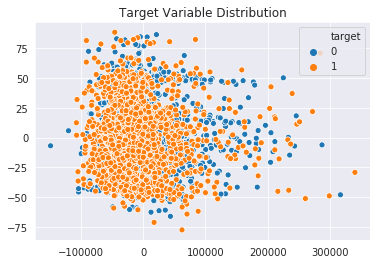

In [11]:
# reduce data to two dimensions
from sklearn.decomposition import PCA
Data_2D = PCA(n_components=2).fit_transform(Data)

sns.scatterplot(Data_2D[:,0], Data_2D[:,1], hue=target)
plt.title("Target Variable Distribution")
plt.show;

### EDA

In [12]:
print(Data.shape)
Data.head()

(2990, 15)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
0,0.1730,0.796,197236,0.467,True,0.004110,6,0.1260,-10.369,1,59,0.1810,107.901,4,0.516
1,0.2870,0.771,189796,0.431,True,0.000003,10,0.0934,-5.423,1,59,0.0577,107.047,4,0.268
2,0.2390,0.664,271088,0.382,False,0.007490,0,0.0943,-9.977,1,61,0.0470,123.214,4,0.126
3,0.9200,0.587,171728,0.229,False,0.000000,10,0.1000,-11.254,0,69,0.1280,75.670,4,0.379
4,0.0328,0.487,367391,0.445,True,0.010400,1,0.0778,-10.959,0,60,0.1130,97.031,4,0.180


In [13]:
Data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
count,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000
mean,0.284759,0.568945,230973.129766,0.616645,0.075503,5.282274,0.173021,-7.590767,0.704348,31.786957,0.058583,122.598363,3.949498,0.443865
std,0.287794,0.119889,53428.311398,0.202962,0.210864,3.599736,0.136851,3.394448,0.456412,21.670001,0.059137,29.343005,0.280619,0.236743
min,0.000010,0.123000,82189.000000,0.006150,0.000000,0.000000,0.014300,-27.235000,0.000000,0.000000,0.022500,48.718000,1.000000,0.030100
25%,0.036300,0.496000,197146.250000,0.474250,0.000000,2.000000,0.095300,-9.391000,0.000000,11.000000,0.031500,99.980000,4.000000,0.256000
50%,0.175000,0.573000,220867.000000,0.642000,0.000020,5.000000,0.119000,-6.882000,1.000000,34.000000,0.039200,121.884500,4.000000,0.425500
75%,0.483000,0.647000,252550.250000,0.785000,0.004685,9.000000,0.202000,-5.194500,1.000000,48.000000,0.057300,141.953500,4.000000,0.620750
max,0.994000,0.946000,570947.000000,0.994000,0.963000,11.000000,0.978000,-0.755000,1.000000,84.000000,0.521000,209.515000,5.000000,0.982000


In [14]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2990 entries, 0 to 2989
Data columns (total 15 columns):
acousticness        2990 non-null float64
danceability        2990 non-null float64
duration_ms         2990 non-null int64
energy              2990 non-null float64
explicit            2990 non-null bool
instrumentalness    2990 non-null float64
key                 2990 non-null int64
liveness            2990 non-null float64
loudness            2990 non-null float64
mode                2990 non-null int64
popularity          2990 non-null int64
speechiness         2990 non-null float64
tempo               2990 non-null float64
time_signature      2990 non-null int64
valence             2990 non-null float64
dtypes: bool(1), float64(9), int64(5)
memory usage: 330.0 KB


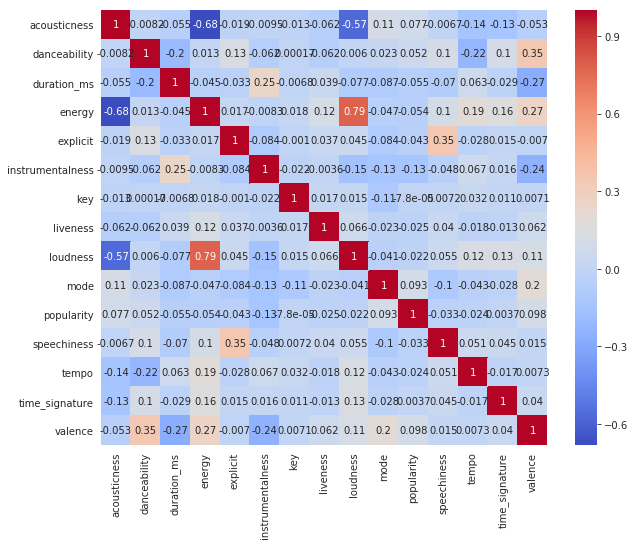

CPU times: user 1.44 s, sys: 598 ms, total: 2.04 s
Wall time: 1.43 s


In [15]:
%%time
plt.figure(figsize=(10,8))
sns.heatmap(Data.corr(), cmap='coolwarm', annot=True)
plt.show();

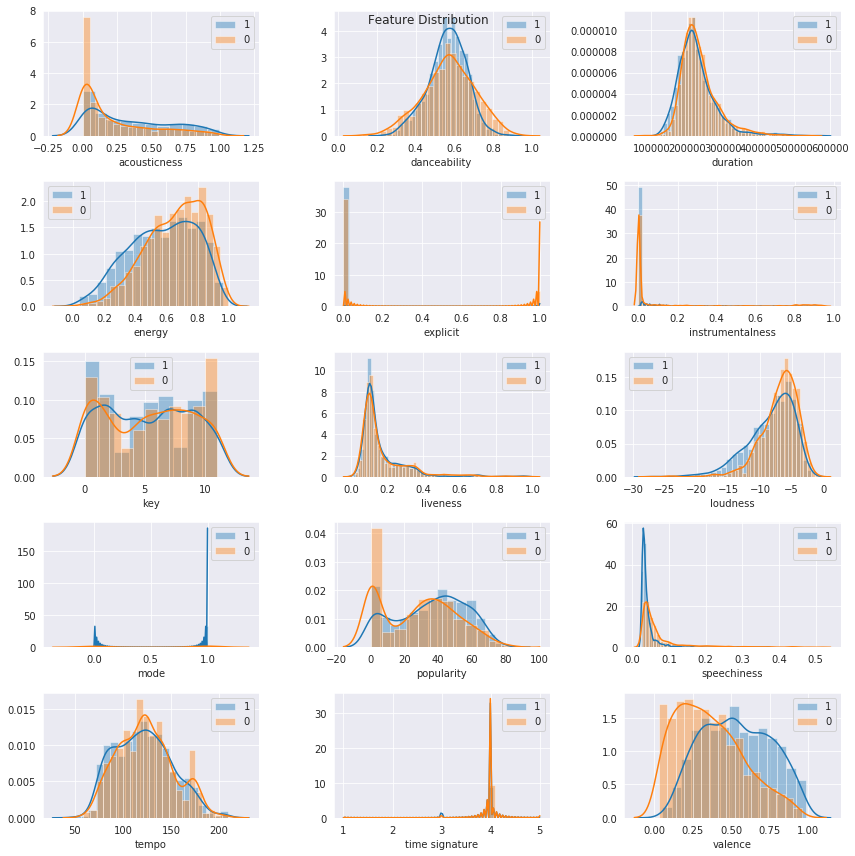

In [0]:
# plot target variable
fig, axes = plt.subplots(5, 3, figsize=(12,12))

sns.distplot(Data["acousticness"].loc[target==1], ax=axes[0,0], label=1)
sns.distplot(Data["acousticness"].loc[target==0], ax=axes[0,0], label=0)
axes[0,0].set_xlabel("acousticness")
axes[0,0].legend()

sns.distplot(Data["danceability"].loc[target==1], ax=axes[0,1], label=1)
sns.distplot(Data["danceability"].loc[target==0], ax=axes[0,1], label=0)
axes[0,1].set_xlabel("danceability")
axes[0,1].legend()

sns.distplot(Data["duration_ms"].loc[target==1], ax=axes[0,2], label=1)
sns.distplot(Data["duration_ms"].loc[target==0], ax=axes[0,2], label=0)
axes[0,2].set_xlabel("duration")
axes[0,2].legend()

sns.distplot(Data["energy"].loc[target==1], ax=axes[1,0], label=1)
sns.distplot(Data["energy"].loc[target==0], ax=axes[1,0], label=0)
axes[1,0].set_xlabel("energy")
axes[1,0].legend()

sns.distplot(Data["explicit"].astype(int).loc[target==1], ax=axes[1,1], label=1)
sns.distplot(Data["explicit"].astype(int).loc[target==0], ax=axes[1,1], label=0)
axes[1,1].set_xlabel("explicit")
axes[1,1].legend()

sns.distplot(Data["instrumentalness"].loc[target==1], ax=axes[1,2], label=1)
sns.distplot(Data["instrumentalness"].loc[target==0], ax=axes[1,2], label=0)
axes[1,2].set_xlabel("instrumentalness")
axes[1,2].legend()

sns.distplot(Data["key"].loc[target==1], ax=axes[2,0], label=1)
sns.distplot(Data["key"].loc[target==0], ax=axes[2,0], label=0)
axes[2,0].set_xlabel("key")
axes[2,0].legend()

sns.distplot(Data["liveness"].loc[target==1], ax=axes[2,1], label=1)
sns.distplot(Data["liveness"].loc[target==0], ax=axes[2,1], label=0)
axes[2,1].set_xlabel("liveness")
axes[2,1].legend()

sns.distplot(Data["loudness"].loc[target==1], ax=axes[2,2], label=1)
sns.distplot(Data["loudness"].loc[target==0], ax=axes[2,2], label=0)
axes[2,2].set_xlabel("loudness")
axes[2,2].legend()

sns.distplot(Data["mode"].loc[target==1], ax=axes[3,0], label=1)
sns.distplot(Data["mode"].loc[target==0], ax=axes[3,0], label=0)
axes[3,0].set_xlabel("mode")
axes[3,0].legend()

sns.distplot(Data["popularity"].loc[target==1], ax=axes[3,1], label=1)
sns.distplot(Data["popularity"].loc[target==0], ax=axes[3,1], label=0)
axes[3,1].set_xlabel("popularity")
axes[3,1].legend()

sns.distplot(Data["speechiness"].loc[target==1], ax=axes[3,2], label=1)
sns.distplot(Data["speechiness"].loc[target==0], ax=axes[3,2], label=0)
axes[3,2].set_xlabel("speechiness")
axes[3,2].legend()

sns.distplot(Data["tempo"].loc[target==1], ax=axes[4,0], label=1)
sns.distplot(Data["tempo"].loc[target==0], ax=axes[4,0], label=0)
axes[4,0].set_xlabel("tempo")
axes[4,0].legend()

sns.distplot(Data["time_signature"].loc[target==1], ax=axes[4,1], label=1)
sns.distplot(Data["time_signature"].loc[target==0], ax=axes[4,1], label=0)
axes[4,1].set_xlabel("time signature")
axes[4,1].legend()

sns.distplot(Data["valence"].loc[target==1], ax=axes[4,2], label=1)
sns.distplot(Data["valence"].loc[target==0], ax=axes[4,2], label=0)
axes[4,2].set_xlabel("valence")
axes[4,2].legend()

fig.suptitle("Feature Distribution")
plt.tight_layout()
plt.show;

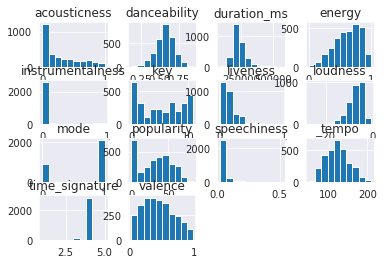

In [0]:
# drop boolean
Data.drop(['explicit'], axis=1).hist();

### Scale Data

In [16]:
#Data = Data_raw.copy()
Data_raw = Data.copy()
Data.drop("explicit", axis=1, inplace=True)
Data_raw.drop("explicit", axis=1, inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data = scaler.fit_transform(Data)
Data = pd.DataFrame(Data, columns=Data_raw.columns)
Data['explicit'] = Audio_features['explicit']
Data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
count,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000
mean,0.286470,0.541853,0.304413,0.618004,0.078404,0.480207,0.164700,0.741852,0.704348,0.378416,0.072383,0.459464,0.737375,0.434673
std,0.289535,0.145673,0.109314,0.205458,0.218966,0.327249,0.142005,0.128189,0.456412,0.257976,0.118630,0.182485,0.070155,0.248705
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.036509,0.453220,0.235203,0.473857,0.000000,0.181818,0.084051,0.673867,0.000000,0.130952,0.018054,0.318799,0.750000,0.237315
50%,0.176048,0.546780,0.283736,0.643671,0.000021,0.454545,0.108644,0.768618,1.000000,0.404762,0.033501,0.455024,0.750000,0.415380
75%,0.485910,0.636695,0.348560,0.788429,0.004865,0.818182,0.194770,0.832345,1.000000,0.571429,0.069809,0.579834,0.750000,0.620496
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


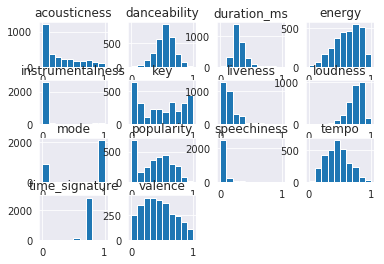

In [17]:
Data.drop(['explicit'], axis=1).hist();

## Model Selection

In [18]:
#from sklearn.linear_model import LogisticRegression
lasso = LogisticRegression(penalty='l1')

model_desc.append("lasso")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=lasso,
                           data=Data,
                           target=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: lasso

Training score: 0.8282783229259589

Validation score: 0.8181818181818182


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur


Cross validation: 0.8074 +/- 0.1031



In [19]:
#from sklearn.linear_model import LogisticRegression
ridge = LogisticRegression(penalty='l2')
model_desc.append("ridge")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=ridge,
                           data=Data,
                           target=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: ridge

Training score: 0.8238180196253345

Validation score: 0.8221925133689839

Cross validation: 0.8051 +/- 0.1168



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [20]:
#from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
model_desc.append("decision tree")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=tree,
                           data=Data,
                           target=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: decision tree

Training score: 0.9995539696699376

Validation score: 0.7593582887700535

Cross validation: 0.7241 +/- 0.074



In [21]:
#from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
model_desc.append("k-nearest neighbors")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=knn,
                           data=Data,
                           target=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: k-nearest neighbors

Training score: 0.8617305976806423

Validation score: 0.7954545454545454

Cross validation: 0.7613 +/- 0.1148



In [22]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
model_desc.append("random forest")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=rfc,
                           data=Data,
                           target=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: random forest

Training score: 1.0

Validation score: 0.8382352941176471

Cross validation: 0.8187 +/- 0.0865



In [23]:
#from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
model_desc.append("multilayer perceptron")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=mlp,
                           data=Data,
                           target=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: multilayer perceptron


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Training score: 0.848349687778769

Validation score: 0.8449197860962567


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Cross validation: 0.8127 +/- 0.0825



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [24]:
#from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.1)
model_desc.append("gradient boosting")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=gbc,
                           data=Data,
                           target=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: gradient boosting

Training score: 0.9148082069580732

Validation score: 0.8582887700534759

Cross validation: 0.8291 +/- 0.0899



### Assessment

In [25]:
model_score[["cv_score", "variance"]].describe()

,cv_score,variance
count,7.000000,7.000000
mean,0.794057,0.095371
std,0.037527,0.016469
min,0.724100,0.074000
25%,0.783200,0.084500
50%,0.807400,0.089900
75%,0.815700,0.108950
max,0.829100,0.116800


In [26]:
model_score = pd.concat([pd.Series(model_desc, name="model"), model_score], axis=1)
model_score.sort_values(by=["cv_score"], ascending=False).head(5)

,model,train_score,test_score,cv_score,variance
6,gradient boosting,0.914808,0.858289,0.8291,0.0899
4,random forest,1.000000,0.838235,0.8187,0.0865
5,multilayer perceptron,0.848350,0.844920,0.8127,0.0825
0,lasso,0.828278,0.818182,0.8074,0.1031
1,ridge,0.823818,0.822193,0.8051,0.1168


## Model Tuning

In [27]:
#from sklearn.ensemble import GradientBoostingClassifier
GradientBoostingClassifier().get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [0]:
# learning rate 
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
# Number of features to consider at every split
max_features = ['log2', 'auto', None]
# Maximum number of levels in tree
max_depths = [int(x) for x in np.linspace(10, 110, num=11)]
max_depths.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# boosting
warm_start = [True, False]

# Create the random grid
param_grid = {'learning_rate': learning_rates,
              'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depths,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'warm_start': warm_start}

In [0]:
# split data
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    Data, target, test_size=0.25, stratify=target)

# sample data for parameter search
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train)

In [30]:
%%time
from sklearn.model_selection import RandomizedSearchCV

model = GradientBoostingClassifier()

search = RandomizedSearchCV(model, param_grid, n_iter=100, cv=3, verbose=2, n_jobs=-1)

search.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished


CPU times: user 2.13 s, sys: 106 ms, total: 2.24 s
Wall time: 1min 25s


In [31]:
best_params = search.best_params_
print(best_params)

{'warm_start': True, 'n_estimators': 400, 'min_samples_split': 0.7000000000000001, 'min_samples_leaf': 0.1, 'max_features': 'auto', 'max_depth': 70, 'learning_rate': 0.25}


## Final Model

In [0]:
# hard code best parameters
best_params = {'warm_start': True,
               'n_estimators': 400,
               'min_samples_split': 0.7000000000000001,
               'min_samples_leaf': 0.1,
               'max_features': 'auto',
               'max_depth': 70,
               'learning_rate': 0.25
              }


Training score: 0.9174843889384479

Validation score: 0.8368983957219251

Cross validation: 0.8117 +/- 0.0766



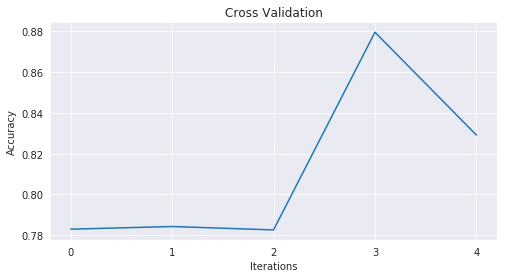

,train_score,test_score,cv_score,variance
0,0.917484,0.836898,0.8117,0.0766


In [32]:
model = GradientBoostingClassifier(**best_params)
supervised_clf(model, Data, target, show_plot=True)

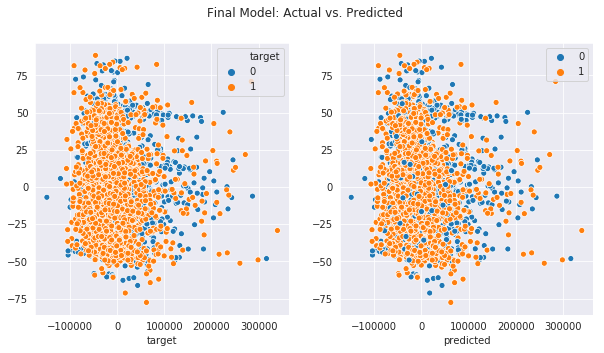

In [33]:
y_pred = model.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Final Model: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

In [0]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall: 90.48931771192281%
Precision: 90.84880636604774%


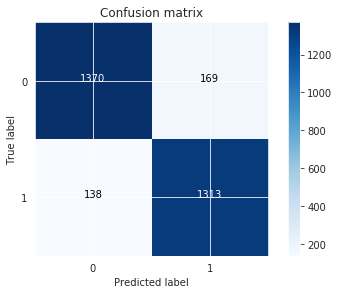

In [35]:
cnf_matrix = confusion_matrix(target, y_pred)

recall_metric = 100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall: {}%".format(recall_metric))

precision_metric = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision: {}%".format(precision_metric))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
#plt.savefig('.png')
plt.show()

ROC-AUC: 0.898


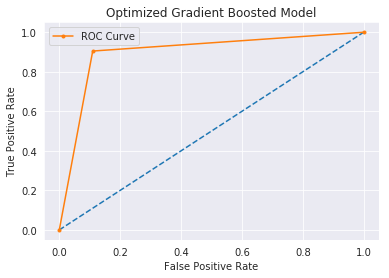

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

# calculate AUC
roc_auc = roc_auc_score(target, y_pred)
print('ROC-AUC: %.3f' % roc_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(target, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Optimized Gradient Boosted Model')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
#plt.savefig('.png')
plt.show()

f1=0.895 auc=0.919 ap=0.848


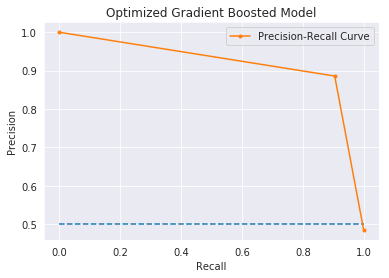

In [37]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import auc, average_precision_score

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(target, y_pred)
# calculate F1 score
f1_score = f1_score(target, y_pred)
# calculate precision-recall AUC
precision_recall_auc = auc(recall, precision)
# calculate average precision score
avg_precision = average_precision_score(target, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1_score,
                                    precision_recall_auc,
                                    avg_precision))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Optimized Gradient Boosted Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
#plt.savefig('.png')
plt.show()

## Conclusion

Our models had mixed performance, some failing to achieve an accuracy above 50% while the best models had an accuracy closer to 80%. With tuning, we weren't able to improve our model much over its base performance.

Ultimately, using audio data made available from Spotify, we were able to classify song mood with ~80% accuracy and very low variance.